The paper we are replicating here is : [N-BEATS: NEURAL BASIS EXPANSION ANALYSIS FOR
INTERPRETABLE TIME SERIES FORECASTING](https://arxiv.org/pdf/1905.10437)

<img src="model.png" width=50% style="display: block; margin-left: auto; margin-right: auto;">

### 

### Preprocess the data

In [9]:
import pandas as pd
df = pd.read_csv('data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [11]:
len(df), df.shape, df.size

(2787, (2787, 5), 13935)

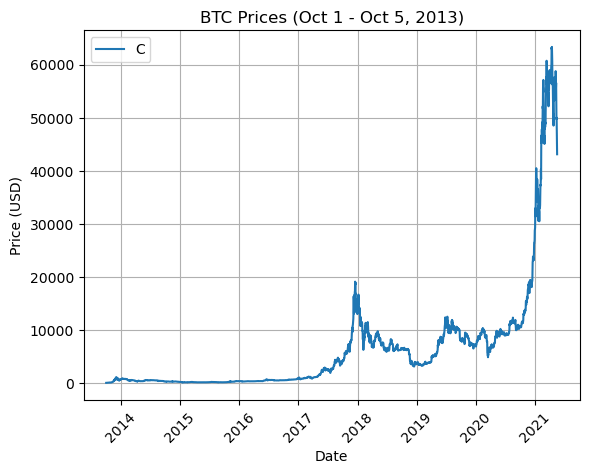

In [12]:
import matplotlib.pyplot as plt

plt.plot(df.index, df["Closing Price (USD)"])

plt.title('BTC Prices (Oct 1 - Oct 5, 2013)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(labels='Closing Price (USD)')
plt.grid(True)
plt.xticks(rotation=45);

### Importing time series data

In [13]:
import csv
from datetime import datetime

timesteps = []
btc_prices = []
with open('data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    next(csv_reader)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], '%Y-%m-%d'))
        btc_prices.append(float(line[2]))

timesteps[:10], btc_prices[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

### Create training and test sets

In [14]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [15]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
btc_prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], btc_prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [18]:
# create train and test splits for time series data
split_size = int(0.8 * len(btc_prices))

# Create train data splits
X_train, y_train = timesteps[:split_size], btc_prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], btc_prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

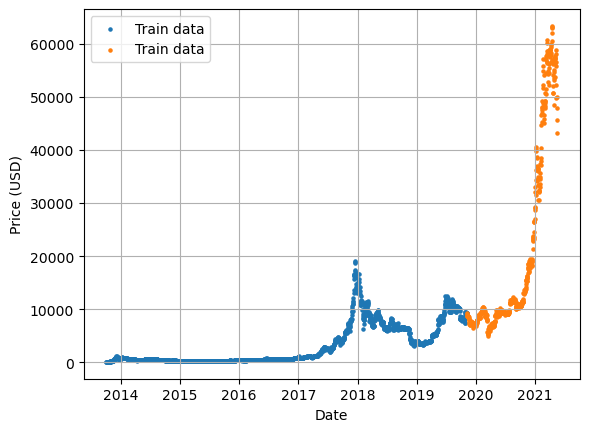

In [19]:
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Train data')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend(fontsize=10)

### Creating a plotting function

In [20]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None, s=5):
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=10)
    plt.grid(True)

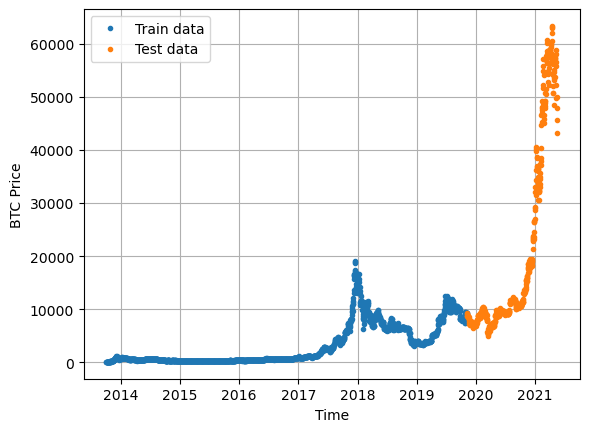

In [21]:
plot_time_series(X_train, y_train, label='Train data')
plot_time_series(X_test, y_test, label='Test data')

## Modelling Experiments

Important terminologies
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

Experiments list:
- 0 Naïve model (baseline)
- Dense model, horizon = 1, window = 7
- Same as 1, horizon = 1, window = 30
- Same as 1, horizon = 7, window = 30
- Conv1D
- LSTM
- Same as 1 (but with multivariate data)
- N-BEATs Algorithm
- Ensemble (multiple models optimized on different loss functions)
- Future prediction model (model to predict future values)
- Same as 1 (but with turkey 🦃 data introduced)

## Model 0: Naive forecast (baseline)

$$\hat{y}_{t} = y_{t-1}$$
> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [22]:
# create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

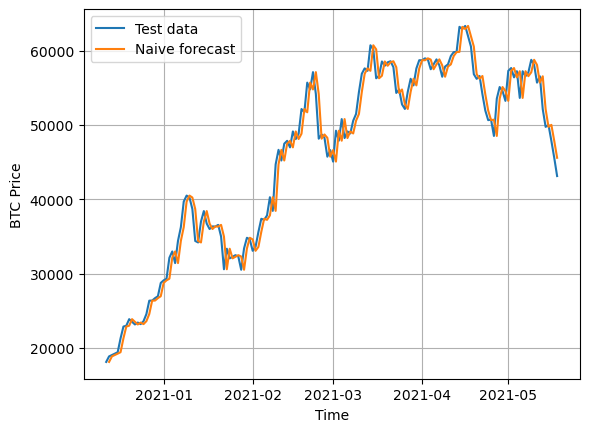

In [23]:
# plot forecast
# plot_time_series(X_train, y_train, label='Train data')
plot_time_series(X_test, y_test, start=400, format='-', label='Test data')
plot_time_series(X_test[1:], naive_forecast, start=400, format='-', label='Naive forecast')

In [24]:
import tensorflow as tf

In [25]:
# mase implementation
def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true-y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

In [26]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [27]:
# function for evaluation metrics
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [28]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## Windowing our dataset
```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [29]:
print(f"We want to use: {btc_prices[:7]} to predict this: {btc_prices[7]}")

We want to use: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] to predict this: 123.033


In [30]:
HORIZON = 1
WINDOW_SIZE = 7

In [31]:
# function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
    return x[:, :-horizon], x[:, -horizon:]

In [32]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [33]:
import numpy as np

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    # create a window of specific window_size
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    # create a 2D array of multiple window steps
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    # index on the target array
    windowed_array = x[window_indexes]
    # get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [35]:
full_windows, full_labels = make_windows(btc_prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [36]:
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [37]:
for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


## Turning windows into training and test sets

In [38]:
# make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [39]:
# create train and test windows 
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

## Make a modelling checkpoint callback

In [40]:
import os

def create_model_checkpoint(model_name, save_path='model_experiments'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              monitor='val_loss',
                                              verbose=0,
                                              save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

In [97]:
import tensorflow as tf
from tensorflow.keras import layers

# set random seed
tf.random.set_seed(42)

# build the model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear'),
], name='model_1_dense')

In [98]:
# compile the model
model_1.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [99]:
# fit the model
model_1_history = model_1.fit(train_windows,
                              train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 2s 71ms/step - loss: 689.7557 - mae: 689.7557 - mse: 2351573.0000 - val_loss: 1457.8884 - val_mae: 1457.8884 - val_mse: 6440624.0000
Epoch 2/100
18/18 [==============================] - 1s 81ms/step - loss: 272.9978 - mae: 272.9978 - mse: 329638.1875 - val_loss: 1307.8030 - val_mae: 1307.8030 - val_mse: 5165014.5000
Epoch 3/100
18/18 [==============================] - 1s 59ms/step - loss: 208.9424 - mae: 208.9424 - mse: 226057.7969 - val_loss: 1200.8185 - val_mae: 1200.8185 - val_mse: 4317393.5000
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 228.4561 - mae: 228.4561 - mse: 240688.0781 - val_loss: 1241.2100 - val_mae: 1241.2100 - val_mse: 4320495.5000
Epoch 5/100
18/18 [==============================] - 1s 61ms/step - loss: 180.6157 - mae: 180.6157 - mse: 174330.7656 - val_loss: 1112.1429 - val_mae: 1112.1429 - val_mse: 3616348.5000
Epoch 6/100
18/18 [==============================] - 1s 74ms/step - loss: 1

In [100]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               3968      
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 20,609
Trainable params: 20,609
Non-trainable params: 0
_________________________________________________________________


In [101]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 607.0544 - mae: 607.0544 - mse: 1265327.1250


[607.0543823242188, 607.0543823242188, 1265327.125]

In [102]:
# load in saved best performing model_1
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 603.3652 - mae: 603.3652 - mse: 1258751.8750


[603.3651733398438, 603.3651733398438, 1258751.875]

### Making forecasts with a model (on the test dataset)

In [103]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [104]:
model_1_preds = make_preds(model_1, test_windows) 
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(552,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8827.735 , 8783.447 , 8671.066 , 8537.316 , 8426.852 , 8459.432 ,
        8250.272 , 8197.605 , 8122.4814, 7744.6895], dtype=float32)>)

In [105]:
tf.squeeze(test_labels).shape, model_1_preds.shape

(TensorShape([552]), TensorShape([552]))

In [106]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 603.3652,
 'mse': 1258751.9,
 'rmse': 1121.9412,
 'mape': 2.7315013,
 'mase': 1.0546881}

In [107]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

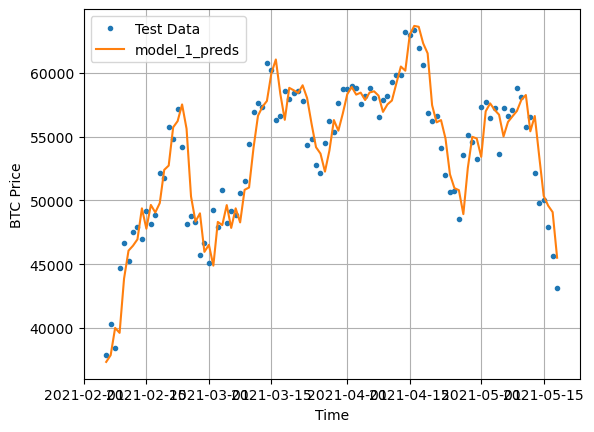

In [108]:
offset = 450

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset, 
                 format="-",
                 label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

In [109]:
HORIZON = 1
WINDOW_SIZE = 30

In [110]:
full_windows, full_labels = make_windows(btc_prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [111]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [112]:
tf.random.set_seed(42)

# build the model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear'),
], name='model_2_dense')

In [113]:
# compile the model
model_2.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [114]:
# fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
18/18 [==============================] - 2s 88ms/step - loss: 1138.0525 - mae: 1138.0525 - mse: 5943978.0000 - val_loss: 1430.8829 - val_mae: 1430.8829 - val_mse: 5714365.0000
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 327.4900 - mae: 327.4900 - mse: 457180.2812 - val_loss: 1569.6447 - val_mae: 1569.6447 - val_mse: 6025539.0000
Epoch 3/100
18/18 [==============================] - 1s 57ms/step - loss: 187.7435 - mae: 187.7435 - mse: 176565.6094 - val_loss: 1004.1003 - val_mae: 1004.1003 - val_mse: 3532611.0000
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 186.5100 - mae: 186.5100 - mse: 163675.5156 - val_loss: 1047.6907 - val_mae: 1047.6907 - val_mse: 3259710.5000
Epoch 5/100
18/18 [==============================] - 1s 56ms/step - loss: 170.6562 - mae: 170.6562 - mse: 144328.9531 - val_loss: 918.9709 - val_mae: 918.9709 - val_mse: 2876850.2500
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 166

In [115]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               3968      
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 20,609
Trainable params: 20,609
Non-trainable params: 0
_________________________________________________________________


In [116]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 593.1271 - mae: 593.1271 - mse: 1220414.3750


[593.1271362304688, 593.1271362304688, 1220414.375]

In [117]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 578.9102 - mae: 578.9102 - mse: 1208704.7500


[578.9102172851562, 578.9102172851562, 1208704.75]

In [119]:
model_2_preds = make_preds(model_2, input_data=test_windows)
model_2_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8772.149, 8738.643, 8720.874, 8544.93 , 8462.486, 8388.839,
       8190.677, 8203.414, 8134.665, 7826.902], dtype=float32)>

In [120]:
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

{'mae': 578.9102,
 'mse': 1208704.8,
 'rmse': 1099.4111,
 'mape': 2.5949128,
 'mase': 1.0119406}

In [121]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

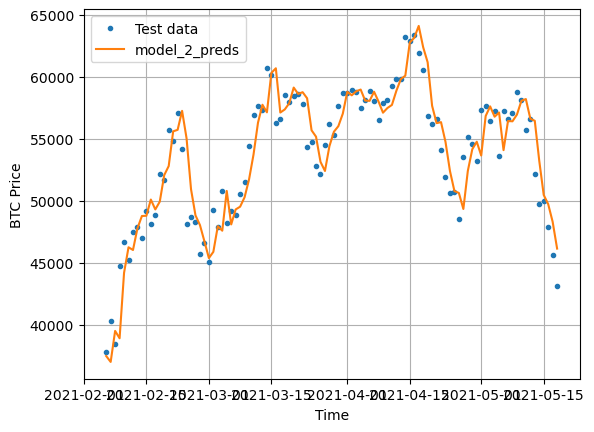

In [124]:
offset = 450

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label='Test data')

plot_time_series(X_test[-len(test_windows):],
                 values=model_2_preds,
                 start=offset,
                 format='-',
                 label='model_2_preds')

## Model 3: Dense (window = 30, horizon = 7)

In [127]:
HORIZON = 7
WINDOW_SIZE = 30

In [128]:
full_windows, full_labels = make_windows(btc_prices, horizon=HORIZON, window_size=WINDOW_SIZE)
len(full_windows), len(full_labels)

(2751, 2751)

In [131]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [142]:
tf.random.set_seed(42)

# build the model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear'),
], name='model_3_dense')

In [143]:
# compile the model
model_3.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [144]:
# fit the model
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
18/18 [==============================] - 2s 79ms/step - loss: 1496.6277 - mae: 1496.6277 - mse: 10908651.0000 - val_loss: 3633.6868 - val_mae: 3633.6868 - val_mse: 33173682.0000
Epoch 2/100
18/18 [==============================] - 1s 58ms/step - loss: 490.8172 - mae: 490.8172 - mse: 1068322.5000 - val_loss: 2194.1587 - val_mae: 2194.1587 - val_mse: 13506534.0000
Epoch 3/100
18/18 [==============================] - 1s 74ms/step - loss: 375.2460 - mae: 375.2460 - mse: 659319.0000 - val_loss: 1787.9928 - val_mae: 1787.9928 - val_mse: 9952892.0000
Epoch 4/100
18/18 [==============================] - 1s 56ms/step - loss: 333.3769 - mae: 333.3769 - mse: 530268.6875 - val_loss: 1653.9651 - val_mae: 1653.9651 - val_mse: 8565165.0000
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 310.6260 - mae: 310.6260 - mse: 462521.9375 - val_loss: 1728.7107 - val_mae: 1728.7107 - val_mse: 8945724.0000
Epoch 6/100
18/18 [==============================] - 1s 59ms/step - l

In [145]:
model_3.summary()

Model: "model_3_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               3968      
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dense_20 (Dense)            (None, 7)                 903       
                                                                 
Total params: 21,383
Trainable params: 21,383
Non-trainable params: 0
_________________________________________________________________


In [146]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 795us/step - loss: 1278.5803 - mae: 1278.5803 - mse: 5629003.5000


[1278.580322265625, 1278.580322265625, 5629003.5]

In [149]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1236.4038 - mae: 1236.4038 - mse: 5471735.5000


[1236.40380859375, 1236.40380859375, 5471735.5]

In [150]:
model_3_preds = make_preds(model_3, input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9455.501 , 9335.292 , 9443.066 , 9466.737 , 9442.42  , 9651.658 ,
        9651.656 ],
       [9085.549 , 9050.863 , 9124.975 , 9161.992 , 9198.038 , 9269.929 ,
        9434.693 ],
       [8917.3125, 8921.926 , 9024.988 , 8924.08  , 9067.798 , 9127.617 ,
        9415.039 ],
       [8990.641 , 9080.781 , 9186.92  , 9139.998 , 9271.142 , 9384.605 ,
        9499.985 ],
       [8786.304 , 8885.983 , 8994.841 , 8955.15  , 8988.142 , 9118.129 ,
        9128.107 ]], dtype=float32)>

In [151]:
model_3_preds.shape, model_2_preds.shape, model_1_preds.shape

(TensorShape([551, 7]), TensorShape([552]), TensorShape([552]))

In [154]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

{'mae': array([  699.11804 ,   446.84222 ,   399.5     ,   595.4157  ,
          425.17453 ,   402.07764 ,   372.23395 ,   452.43463 ,
          484.63232 ,   554.2142  ,   768.0516  ,   790.46747 ,
          916.2269  ,   967.4787  ,   753.1183  ,   246.7869  ,
          156.59842 ,   195.21059 ,   169.80197 ,   216.72537 ,
          279.28683 ,   315.65668 ,   541.04974 ,   441.82666 ,
          305.1474  ,   206.23312 ,   169.52184 ,   116.15046 ,
          141.5452  ,   197.45654 ,   296.7278  ,   312.89154 ,
          328.20786 ,   312.41177 ,   306.5821  ,   297.43472 ,
          357.88315 ,   232.8065  ,   182.35582 ,   286.87912 ,
          514.601   ,    69.723564,    42.633648,   138.20103 ,
          130.76807 ,   231.28865 ,   148.71324 ,   198.95682 ,
          102.92257 ,   128.42662 ,   133.05168 ,   156.57582 ,
          223.6301  ,   223.22928 ,   217.50098 ,   323.13998 ,
          474.49588 ,   411.20215 ,   467.6225  ,   541.19617 ,
          317.0376  ,   148.89809

In [155]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1236.4038 - mae: 1236.4038 - mse: 5471735.5000


[1236.40380859375, 1236.40380859375, 5471735.5]

In [156]:
tf.reduce_mean(model_3_results["mae"]).numpy()

1236.4037

In [157]:
model_2_results["mae"].ndim

0

In [158]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [159]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1236.4037,
 'mse': 5471736.0,
 'rmse': 1417.903,
 'mape': 5.603118,
 'mase': 2.200111}

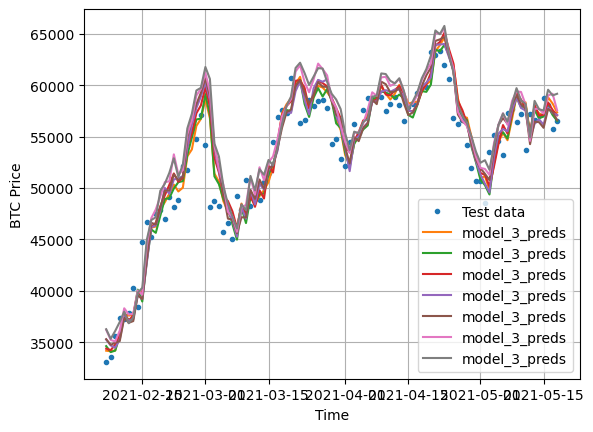

In [160]:
offset = 450
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_3_preds,
                 start=offset,
                 format='-',
                 label="model_3_preds")

In [161]:
model_3_preds[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([9455.501, 9335.292, 9443.066, 9466.737, 9442.42 , 9651.658,
       9651.656], dtype=float32)>

In [162]:
tf.reduce_mean(model_3_preds[0])

<tf.Tensor: shape=(), dtype=float32, numpy=9492.333>

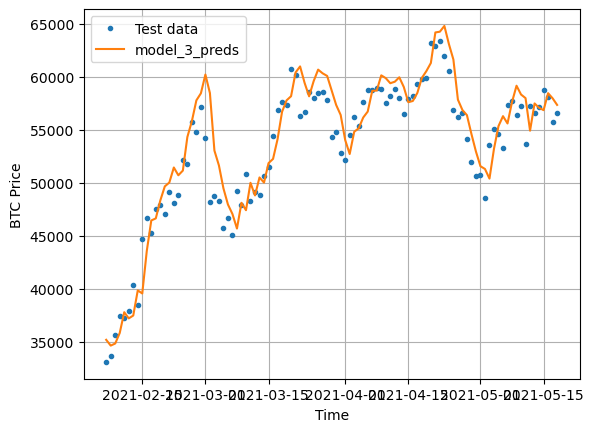

In [163]:
offset = 450

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test data")

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 start=offset,
                 format="-", 
                 label="model_3_preds")